In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import time
from benchmarkUtils import Benchmark

In [2]:
pd.set_option("display.width", 10000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", None)

TESTING = False
TESTING_SIZE = 0.01
random_state = 245
benchmark_util = Benchmark(iter_n=10)

In [3]:
def test_train_val_split(df, random_state=random_state):
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        df.iloc[:, :-1], df.iloc[:, -1], test_size=0.3, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.5, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
prepend_path = "./"

# Define the paths to the files
known_attacks_path = f"{prepend_path}/data/probe_known_attacks_small.csv"
similar_attacks_path = f"{prepend_path}/data/probe_similar_attacks_small.csv"
new_attacks_path = f"{prepend_path}/data/probe_new_attacks_small.csv"

# Example to print the paths (optional, for debugging purposes)
print("Known Attacks Path:", known_attacks_path)
print("Similar Attacks Path:", similar_attacks_path)
print("New Attacks Path:", new_attacks_path)

Known Attacks Path: .//data/probe_known_attacks_small.csv
Similar Attacks Path: .//data/probe_similar_attacks_small.csv
New Attacks Path: .//data/probe_new_attacks_small.csv


In [5]:
df = pd.read_csv(known_attacks_path, low_memory=False)

In [6]:
if TESTING:
    df = df.sample(frac=TESTING_SIZE, random_state=random_state)
    df.reset_index(drop=True, inplace=True)
df.shape

(85060, 51)

In [7]:
df.columns

Index(['ip_type', 'ip_len', 'ip_id', 'ip_offset', 'ip_RF', 'ip_DF', 'ip_MF', 'ip_proto', 'ip_checksum', 'udp_sport', 'udp_dport', 'udp_len', 'udp_chk', 'icmp_type', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_frst', 'tcp_fpush', 'tcp_fack', 'tcp_furg', 'fr_length', 'conn_status', 'count_fr_src_dst', 'count_fr_dst_src', 'count_serv_src_dst', 'count_serv_dst_src', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_pushed_src_dst', 'num_pushed_dst_src', 'num_syn_fin_src_dst', 'num_syn_fin_dst_src', 'num_fin_src_dst', 'num_fin_dst_src', 'num_ack_src_dst', 'num_ack_dst_src', 'num_syn_src_dst', 'num_syn_dst_src', 'num_rst_src_dst', 'num_rst_dst_src', 'first_packet', 'first_serv_packet', 'class'], dtype='object')

In [8]:
df.head()

,ip_type,ip_len,ip_id,ip_offset,ip_RF,ip_DF,ip_MF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
0,0,552,13968,0,0,0,0,6,49165,0,0,0,0,0,0,0,80,54640,2925601313,2784850843,0,0,0,0,1,0,512,6,416,579,416,579,5121,65535,5121,65535,1,0,0,0,0,0,415,579,1,1,0,0,0,0,normal
1,0,552,13969,0,0,0,0,6,49164,0,0,0,0,0,0,0,80,54640,2925601825,2784850843,0,0,0,0,1,0,512,6,416,580,416,580,5121,65535,5121,65535,1,0,0,0,0,0,415,580,1,1,0,0,0,0,normal
2,0,40,25941,0,0,0,0,6,44274,0,0,0,0,0,0,0,58502,80,0,394780220,0,0,0,0,1,0,6,1,1,0,1,0,6,0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,attack
3,0,52,56525,0,0,1,0,6,56195,0,0,0,0,0,0,0,56069,80,7130052,2926006578,0,0,0,0,1,0,12,6,31,37,31,37,500,16916,500,16916,1,0,0,0,0,0,30,37,1,1,0,0,0,0,normal
4,0,52,27415,0,0,1,0,6,19834,0,0,0,0,0,0,0,54640,80,2784850843,2925599265,0,0,0,0,1,0,12,6,417,580,417,580,5133,65535,5133,65535,1,0,0,0,0,0,416,580,1,1,0,0,0,0,normal


In [9]:
df.describe(include="all")

,ip_type,ip_len,ip_id,ip_offset,ip_RF,ip_DF,ip_MF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
count,85060.000000,85060.000000,85060.000000,85060.0,85060.0,85060.000000,85060.0,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,8.506000e+04,8.506000e+04,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48432
mean,0.754667,100.386174,31165.699577,0.0,0.0,0.363931,0.0,8.039925,33087.734246,7335.142699,4493.626499,7.966353,6440.783964,0.062168,0.054456,620.470245,27821.129226,13938.420973,1.471971e+09,1.008449e+09,0.553903,0.568152,0.527980,0.486151,0.913884,0.473360,65.945121,5.869821,405.885857,520.797084,328.958617,291.029732,10105.989772,28114.899694,8279.352187,17662.463144,40.784376,44.620327,36.238349,74.642147,83.044075,19.918340,162.481060,265.684047,113.913144,30.737621,37.778486,140.026957,0.003492,0.089560,NaN
std,5.925130,191.572060,19906.379891,0.0,0.0,0.481132,0.0,4.450021,18710.567547,17846.337785,13369.749481,21.495346,15363.667022,0.491994,0.400504,4495.728132,24382.931287,20878.971872,1.419588e+09,1.377824e+09,0.820632,0.819572,0.821924,0.822284,0.710662,0.821969,190.189264,4.249343,1235.773115,1367.500610,1956.456315,1413.383988,17353.336438,41288.108509,17651.159114,29433.799558,1117.698208,1485.625396,786.401261,1124.563326,1294.569237,968.524034,1637.743817,1173.387641,1556.568989,1363.660077,1310.832438,666.280141,0.058987,0.285552,NaN
min,0.000000,28.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,40.000000,14018.000000,0.0,0.0,0.000000,0.0,6.000000,16980.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,80.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000,39.000000,38.000000,5.000000,2.000000,813.000000,18.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,0.000000,52.000000,31076.500000,0.0,0.0,0.000000,0.0,6.000000,34049.500000,0.000000

It seems as though ip_RF, ip_MF, and ip_offset do not contain any valuable information. They can be removed

In [10]:
df = df.drop(columns=["ip_RF", "ip_MF", "ip_offset"])

In [11]:
df.columns

Index(['ip_type', 'ip_len', 'ip_id', 'ip_DF', 'ip_proto', 'ip_checksum', 'udp_sport', 'udp_dport', 'udp_len', 'udp_chk', 'icmp_type', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_frst', 'tcp_fpush', 'tcp_fack', 'tcp_furg', 'fr_length', 'conn_status', 'count_fr_src_dst', 'count_fr_dst_src', 'count_serv_src_dst', 'count_serv_dst_src', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_pushed_src_dst', 'num_pushed_dst_src', 'num_syn_fin_src_dst', 'num_syn_fin_dst_src', 'num_fin_src_dst', 'num_fin_dst_src', 'num_ack_src_dst', 'num_ack_dst_src', 'num_syn_src_dst', 'num_syn_dst_src', 'num_rst_src_dst', 'num_rst_dst_src', 'first_packet', 'first_serv_packet', 'class'], dtype='object')

In [12]:
print(df["class"].value_counts())
print(df["class"].value_counts(normalize=True) * 100)

class
normal    48432
attack    36628
Name: count, dtype: int64
class
normal    56.938632
attack    43.061368
Name: proportion, dtype: float64


In [13]:
df.dtypes

ip_type                    int64
ip_len                     int64
ip_id                      int64
ip_DF                      int64
ip_proto                   int64
ip_checksum                int64
udp_sport                  int64
udp_dport                  int64
udp_len                    int64
udp_chk                    int64
icmp_type                  int64
icmp_code                  int64
icmp_chk                   int64
tcp_sport                  int64
tcp_dport                  int64
tcp_seq                    int64
tcp_ack                    int64
tcp_ffyn                   int64
tcp_fsyn                   int64
tcp_frst                   int64
tcp_fpush                  int64
tcp_fack                   int64
tcp_furg                   int64
fr_length                  int64
conn_status                int64
count_fr_src_dst           int64
count_fr_dst_src           int64
count_serv_src_dst         int64
count_serv_dst_src         int64
num_bytes_src_dst          int64
num_bytes_

In [14]:
df["ip_type"].value_counts()

ip_type
0      83516
40      1528
192       16
Name: count, dtype: int64

In [15]:
df["class"] = df["class"].replace({"normal": 0, "attack": 1})

In [16]:
df = df.astype(float)

In [17]:
corr = df.corr()

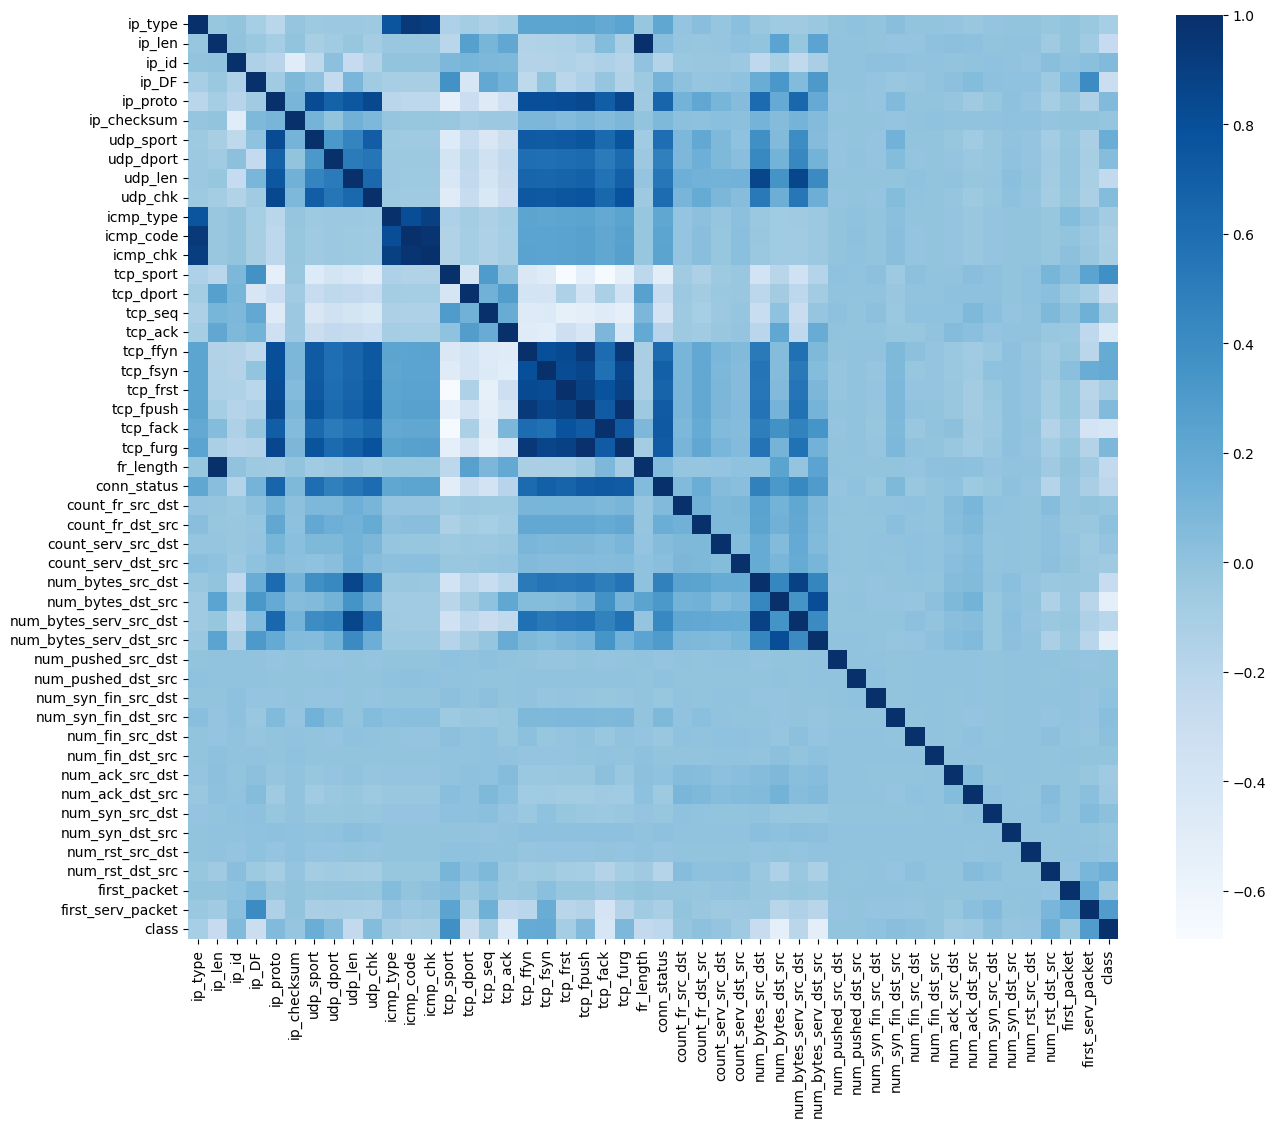

In [18]:
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap="Blues")
plt.show()

In [19]:
corr["class"].sort_values(ascending=False)

class                     1.000000
tcp_sport                 0.376711
first_serv_packet         0.288401
tcp_fsyn                  0.183862
tcp_ffyn                  0.179369
udp_sport                 0.159150
num_rst_dst_src           0.148479
tcp_furg                  0.081623
ip_id                     0.070370
ip_proto                  0.068846
tcp_fpush                 0.068064
udp_chk                   0.050838
udp_dport                 0.043169
num_syn_fin_dst_src       0.032562
num_syn_src_dst           0.023503
num_fin_src_dst           0.018179
count_fr_dst_src          0.016557
num_syn_fin_src_dst       0.010139
num_pushed_src_dst       -0.005405
num_pushed_dst_src       -0.006834
num_fin_dst_src          -0.008403
num_rst_src_dst          -0.008925
count_serv_src_dst       -0.010181
ip_checksum              -0.015762
num_syn_dst_src          -0.017306
count_fr_src_dst         -0.018505
first_packet             -0.032560
num_ack_dst_src          -0.042007
num_ack_src_dst     

The target feature does not seem to have very strong correlations with any particular feature.

In [20]:
# remove all features with an absolute correlation of less than 0.1
cols_corr_gt1 = corr["class"][abs(corr["class"]) > 0.1].index

In [21]:
print(cols_corr_gt1)
print(len(cols_corr_gt1))

Index(['ip_len', 'ip_DF', 'udp_sport', 'udp_len', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_fack', 'fr_length', 'conn_status', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_rst_dst_src', 'first_serv_packet', 'class'], dtype='object')
21


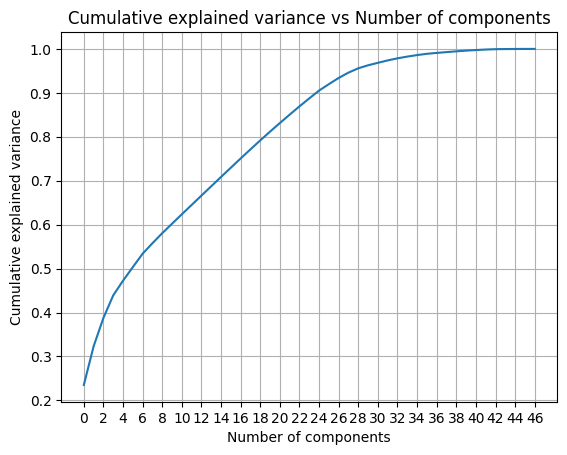

In [22]:
X = df.drop(columns=["class"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=len(df.columns) - 1)
X_pca = pca.fit_transform(X_scaled)

pca_cumsum = pca.explained_variance_ratio_.cumsum()
plt.plot(pca_cumsum)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance vs Number of components")
plt.grid()
plt.xticks(range(0, len(df.columns) - 1, 2))
plt.show()

- at n=27, we have 95% of the variance explained

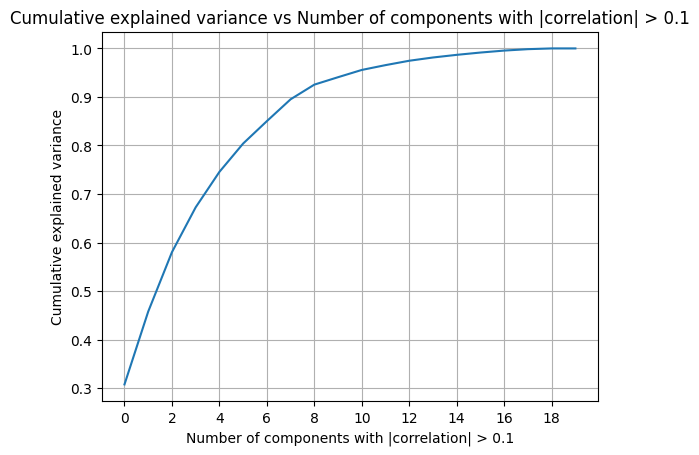

In [23]:
X_gt1 = df[cols_corr_gt1]
X_gt1 = X_gt1.drop(columns=["class"])

scaler_gt1 = StandardScaler()
X_gt1_scaled = scaler_gt1.fit_transform(X_gt1)

pca_corr_gt1 = PCA(n_components=len(cols_corr_gt1) - 1)
X_gt1_pca = pca_corr_gt1.fit_transform(X_gt1_scaled)

pca_cumsum = pca_corr_gt1.explained_variance_ratio_.cumsum()
plt.plot(pca_cumsum)
plt.xlabel("Number of components with |correlation| > 0.1")
plt.ylabel("Cumulative explained variance")
plt.title(
    "Cumulative explained variance vs Number of components with |correlation| > 0.1"
)
plt.grid()
plt.xticks(range(0, len(cols_corr_gt1) - 1, 2))
plt.show()

- at n=10 of the selected features, we have 95% of the variance explained

# Modelling

In [24]:
_, _, __X__, _, _, __y__ = test_train_val_split(df)
df_known_attacks = pd.DataFrame(__X__)
df_known_attacks["class"] = __y__
df_known_attacks.reset_index(drop=True, inplace=True)

In [25]:
df_similar_attacks = pd.read_csv(similar_attacks_path, low_memory=False)
df_similar_attacks = df_similar_attacks.drop(columns=["ip_RF", "ip_MF", "ip_offset"])
df_similar_attacks["class"] = df_similar_attacks["class"].replace({"normal": 0, "attack": 1})

df_new_attacks = pd.read_csv(new_attacks_path, low_memory=False)
df_new_attacks = df_new_attacks.drop(columns=["ip_RF", "ip_MF", "ip_offset"])
df_new_attacks["class"] = df_new_attacks["class"].replace({"normal": 0, "attack": 1})

In [26]:
if TESTING:
    df_similar_attacks = df_similar_attacks.sample(frac=TESTING_SIZE, random_state=random_state)
    df_similar_attacks.reset_index(drop=True, inplace=True)
    df_new_attacks = df_new_attacks.sample(frac=TESTING_SIZE, random_state=random_state)
    df_new_attacks.reset_index(drop=True, inplace=True)

In [27]:
def pipeline_scaled(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs:
        raise ValueError("df and scaler must be passed as keyword arguments for pipeline_scaled")
    df = kwargs["df"]
    scaler = kwargs["scaler"]

    df_ = df.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pd.DataFrame(df_, columns=df.columns[:-1])
    df_["class"] = df["class"]
    return df_

In [28]:
def pipeline_corr_gt1_scaled(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs or "cols" not in kwargs:
        raise ValueError("df, scaler, and cols must be passed as keyword arguments for pipeline_corr_gt1_scaled")
    df = kwargs["df"]
    scaler = kwargs["scaler"]
    cols = kwargs["cols"]

    df_ = df[cols]
    df_ = df_.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pd.DataFrame(df_, columns=cols[:-1])
    df_["class"] = df["class"]
    return df_

In [29]:
def pipeline_pca(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs or "pca" not in kwargs:
        raise ValueError("df, scaler, and pca must be passed as keyword arguments for pipeline_pca")
    df = kwargs["df"]
    scaler = kwargs["scaler"]
    pca = kwargs["pca"]

    df_ = df.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pca.transform(df_)
    df_ = df_[:, :27]
    df_ = pd.DataFrame(df_)
    df_["class"] = df["class"]
    return df_

In [30]:
def pipeline_corr_gt1_pca(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs or "cols" not in kwargs or "pca" not in kwargs:
        raise ValueError("df, scaler, cols, and pca must be passed as keyword arguments for pipeline_corr_gt1_pca")
    df = kwargs["df"]
    scaler = kwargs["scaler"]
    cols = kwargs["cols"]
    pca = kwargs["pca"]

    df_ = df[cols]
    df_ = df_.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pca.transform(df_)
    df_ = df_[:, :10]
    df_ = pd.DataFrame(df_)
    df_["class"] = df["class"]
    return df_

## Random Forest

In [31]:
random_forest_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [32]:
verbose = 3
cv = 3
n_jobs = None

### All features scaled

In [33]:
df_scaled = pipeline_scaled(df=df, scaler=scaler)
df_scaled.head()

,ip_type,ip_len,ip_id,ip_DF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
0,-0.127368,2.357424,-0.863934,-0.756411,-0.458411,0.859266,-0.411019,-0.336106,-0.37061,-0.419224,-0.12636,-0.135969,-0.138014,-1.137734,1.949417,1.023986,1.289289,-0.674975,-0.693234,-0.642375,-0.591224,0.121177,-0.575889,2.345335,0.030635,0.008185,0.042562,0.044490,0.203746,-0.287266,0.906322,-0.178933,1.626457,-0.035595,-0.030035,-0.046082,-0.066375,-0.064148,-0.020566,0.154188,0.267020,-0.072540,-0.021807,-0.02882,-0.210164,-0.059194,-0.313641,0.0
1,-0.127368,2.357424,-0.863884,-0.756411,-0.458411,0.859213,-0.411019,-0.336106,-0.37061,-0.419224,-0.12636,-0.135969,-0.138014,-1.137734,1.949417,1.023987,1.289289,-0.674975,-0.693234,-0.642375,-0.591224,0.121177,-0.575889,2.345335,0.030635,0.008185,0.043293,0.044490,0.204454,-0.287266,0.906322,-0.178933,1.626457,-0.035595,-0.030035,-0.046082,-0.066375,-0.064148,-0.020566,0.154188,0.267872,-0.072540,-0.021807,-0.02882,-0.210164,-0.059194,-0.313641,0.0
2,-0.127368,-0.315216,-0.262465,-0.756411,-0.458411,0.597862,-0.411019,-0.336106,-0.37061,-0.419224,-0.12636,-0.135969,-0.138014,1.258300,-0.663754,-1.036906,-0.445392,-0.674975,-0.693234,-0.642375,-0.591224,0.121177,-0.575889,-0.315189,-1.146024,-0.327640,-0.380841,-0.167630,-0.205911,-0.582023,-0.680948,-0.468717,-0.600078,-0.036490,-0.030035,-0.046082,-0.066375,-0.064148,-0.020566,-0.098600,-0.226426,-0.073183,-0.022541,-0.02882,-0.210164,16.893706,3.188363,1.0
3,-0.127368,-0.252576,1.273936,1.322033,-0.458411,1.234992,-0.411019,-0.336106,-0.37061,-0.419224,-0.12636,-0.135969,-0.138014,1.158517,-0.663754,-1.031884,1.391738,-0.674975,-0.693234,-0.642375,-0.591224,0.121177,-0.575889,-0.283641,0.030635,-0.303363,-0.353784,-0.152296,-0.179733,-0.553556,-0.271239,-0.440730,-0.025361,-0.035595,-0.030035,-0.046082,-0.066375,-0.064148,-0.020566,-0.080893,-0.194893,-0.072540,-0.021807,-0.02882,-0.210164,-0.059194,-0.313641,0.0
4,-0.127368,-0.252576,-0.188418,1.322033,-0.458411,-0.708360,-0.411019,-0.336106,-0.37061,-0.419224,-0.12636,-0.135969,-0.138014,1.099910,-0.663754,0.924837,1.391442,-0.674975,-0.693234,-0.642375,-0.591224,0.121177,-0.575889,-0.283641,0.030635,0.008994,0.043293,0.045001,0.204454,-0.286574,0.906322,-0.178253,1.626457,-0.035595,-0.030035,-0.046082,-0.066375,-0.064148,-0.020566,0.154799,0.267872,-0.072540,-0.021807,-0.02882,-0.210164,-0.059194,-0.313641,0.0


In [34]:
(
    X_scaled_train,
    X_scaled_val,
    X_scaled_test,
    y_scaled_train,
    y_scaled_val,
    y_scaled_test,
) = test_train_val_split(df_scaled)

In [35]:
from sklearn.ensemble import RandomForestClassifier

RF_scaled_baseline = RandomForestClassifier(random_state=random_state)
RF_scaled_baseline.fit(X_scaled_train, y_scaled_train)

RandomForestClassifier(random_state=245)

In [36]:
print(classification_report(y_scaled_val, RF_scaled_baseline.predict(X_scaled_val)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7154
         1.0       1.00      1.00      1.00      5605

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759



In [37]:
RF_scaled_grid = GridSearchCV(RandomForestClassifier(random_state=random_state), random_forest_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
RF_scaled_grid.fit(X_scaled_val, y_scaled_val)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=1.000 total time=   0.5s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=1.000 total time=   0.5s
[CV 3/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.999 total time=   0.4s
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   0.9s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   0.9s
[CV 3/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.999 total time=   0.9s
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=1.000 total time=   1.8s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=1.000 

[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=1.000 total time=   1.7s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.999 total time=   1.7s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.999 total time=   1.6s
[CV 1/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=1.000 total time=   0.5s
[CV 2/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=1.000 total time=   0.4s
[CV 3/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.999 total time=   0.4s
[CV 1/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   0.9s
[CV 2/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   0.9s
[CV 3/3] END max_depth=20, min_samples_leaf=1, min_samples_

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=245),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             verbose=3)

In [38]:
print(RF_scaled_grid.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [39]:
RF_scaled = RandomForestClassifier(**RF_scaled_grid.best_params_, random_state=random_state)
RF_scaled.fit(X_scaled_train, y_scaled_train)

RandomForestClassifier(n_estimators=200, random_state=245)

In [40]:
print(classification_report(y_scaled_test, RF_scaled.predict(X_scaled_test)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759



In [41]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        RF_scaled,
        f"Random Forest {RF_scaled_grid.best_params_}",
        "Known attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler
        )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Data size: 12759
Accuracy: 0.9998432479034407
Precision: 0.9998198198198198
Recall: 0.9998198198198198
F1: 0.9998198198198198
Time per data per iter: 182.9698123


In [42]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        RF_scaled,
        f"Random Forest {RF_scaled_grid.best_params_}",
        "Similar attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler
        )

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15969
           1       1.00      0.97      0.98     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.98      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Data size: 26409
Accuracy: 0.9874663940323375
Precision: 1.0
Recall: 0.9682950191570882
F1: 0.9838921602024429
Time per data per iter: 304.43883189999997


In [43]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        RF_scaled,
        f"Random Forest {RF_scaled_grid.best_params_}",
        "New attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       1.00      0.00      0.01     17752

    accuracy                           0.77     75890
   macro avg       0.88      0.50      0.44     75890
weighted avg       0.82      0.77      0.67     75890


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Data size: 75890
Accuracy: 0.7668203979443932
Precision: 1.0
Recall: 0.0031545741324921135
F1: 0.006289308176100629
Time per data per iter: 842.7715678


In [44]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",Known attacks,All features scaled,12759,0.999843,0.99982,0.999820,0.999820,182.969812
1,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",Similar attacks,All features scaled,26409,0.987466,1.00000,0.968295,0.983892,304.438832
2,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",New attacks,All features scaled,75890,0.766820,1.00000,0.003155,0.006289,842.771568


### Features with |correlation| > 0.1 scaled

In [45]:
df_corr_gt1_scaled = pipeline_corr_gt1_scaled(df=df, scaler=scaler_gt1, cols=cols_corr_gt1)
df_corr_gt1_scaled.head()

,ip_len,ip_DF,udp_sport,udp_len,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_fack,fr_length,conn_status,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_rst_dst_src,first_serv_packet,class
0,2.357424,-0.756411,-0.411019,-0.37061,-0.135969,-0.138014,-1.137734,1.949417,1.289289,-0.674975,-0.693234,0.121177,2.345335,0.030635,-0.287266,0.906322,-0.178933,1.626457,-0.210164,-0.313641,0.0
1,2.357424,-0.756411,-0.411019,-0.37061,-0.135969,-0.138014,-1.137734,1.949417,1.289289,-0.674975,-0.693234,0.121177,2.345335,0.030635,-0.287266,0.906322,-0.178933,1.626457,-0.210164,-0.313641,0.0
2,-0.315216,-0.756411,-0.411019,-0.37061,-0.135969,-0.138014,1.258300,-0.663754,-0.445392,-0.674975,-0.693234,0.121177,-0.315189,-1.146024,-0.582023,-0.680948,-0.468717,-0.600078,-0.210164,3.188363,1.0
3,-0.252576,1.322033,-0.411019,-0.37061,-0.135969,-0.138014,1.158517,-0.663754,1.391738,-0.674975,-0.693234,0.121177,-0.283641,0.030635,-0.553556,-0.271239,-0.440730,-0.025361,-0.210164,-0.313641,0.0
4,-0.252576,1.322033,-0.411019,-0.37061,-0.135969,-0.138014,1.099910,-0.663754,1.391442,-0.674975,-0.693234,0.121177,-0.283641,0.030635,-0.286574,0.906322,-0.178253,1.626457,-0.210164,-0.313641,0.0


In [46]:
(
    X_corr_gt1_scaled_train,
    X_corr_gt1_scaled_val,
    X_corr_gt1_scaled_test,
    y_corr_gt1_scaled_train,
    y_corr_gt1_scaled_val,
    y_corr_gt1_scaled_test,
) = test_train_val_split(df_corr_gt1_scaled)

In [47]:
RF_corr_gt1_scaled_baseline = RandomForestClassifier(random_state=random_state)
RF_corr_gt1_scaled_baseline.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

RandomForestClassifier(random_state=245)

In [48]:
print(classification_report(y_corr_gt1_scaled_val, RF_corr_gt1_scaled_baseline.predict(X_corr_gt1_scaled_val)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7154
         1.0       1.00      1.00      1.00      5605

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759



In [49]:
RF_corr_gt1_scaled_grid = GridSearchCV(RandomForestClassifier(random_state=random_state), random_forest_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
RF_corr_gt1_scaled_grid.fit(X_corr_gt1_scaled_val, y_corr_gt1_scaled_val)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=1.000 total time=   0.3s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=1.000 total time=   0.3s
[CV 3/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.999 total time=   0.3s
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   0.6s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   0.6s
[CV 3/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.999 total time=   0.6s
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=1.000 total time=   1.2s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=1.000 

[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=1.000 total time=   1.2s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=1.000 total time=   1.1s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.999 total time=   1.2s
[CV 1/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=1.000 total time=   0.3s
[CV 2/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=1.000 total time=   0.3s
[CV 3/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.999 total time=   0.3s
[CV 1/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   0.6s
[CV 2/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   0.6s
[CV 3/3] END max_depth=20, min_samples_leaf=1, min_samples_

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=245),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             verbose=3)

In [50]:
print(RF_corr_gt1_scaled_grid.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [51]:
RF_corr_gt1_scaled = RandomForestClassifier(**RF_corr_gt1_scaled_grid.best_params_, random_state=random_state)
RF_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

RandomForestClassifier(random_state=245)

In [52]:
print(classification_report(y_corr_gt1_scaled_test, RF_corr_gt1_scaled.predict(X_corr_gt1_scaled_test)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759



In [53]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        RF_corr_gt1_scaled,
        f"Random Forest {RF_corr_gt1_scaled_grid.best_params_}",
        "Known attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Data size: 12759
Accuracy: 0.9998432479034407
Precision: 0.9998198198198198
Recall: 0.9998198198198198
F1: 0.9998198198198198
Time per data per iter: 89.53166440000001


In [54]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        RF_corr_gt1_scaled,
        f"Random Forest {RF_corr_gt1_scaled_grid.best_params_}",
        "Similar attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15969
           1       1.00      0.97      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Data size: 26409
Accuracy: 0.9886402362830853
Precision: 0.9998028391167192
Recall: 0.971455938697318
F1: 0.985425573260785
Time per data per iter: 147.984605


In [55]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        RF_corr_gt1_scaled,
        f"Random Forest {RF_corr_gt1_scaled_grid.best_params_}",
        "New attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.92      0.01      0.01     17752

    accuracy                           0.77     75890
   macro avg       0.85      0.50      0.44     75890
weighted avg       0.80      0.77      0.67     75890


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Data size: 75890
Accuracy: 0.767242060877586
Precision: 0.9230769230769231
Recall: 0.005407841369986481
F1: 0.01075268817204301
Time per data per iter: 403.8518405


In [56]:
benchmark_util.display

<bound method Benchmark.display of <benchmarkUtils.Benchmark object at 0x76ed349a9b70>>

### All features with 95% PCA

In [57]:
df_pca = pipeline_pca(df=df, scaler=scaler, pca=pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,class
0,-1.516735,-1.070537,4.199741,-1.394049,0.957756,0.583451,1.314415,0.300038,-0.100427,-0.074686,0.018951,-0.068260,-0.085588,-0.029476,-0.045298,0.029734,0.115908,0.130896,-0.111055,-0.021935,-0.102228,0.114430,0.068183,-0.159354,0.227031,-0.697531,0.338713,0.0
1,-1.516680,-1.070594,4.199846,-1.393880,0.957351,0.583922,1.314396,0.300622,-0.100220,-0.074792,0.018950,-0.068254,-0.085581,-0.029455,-0.045232,0.029740,0.115972,0.130898,-0.111276,-0.022129,-0.102981,0.114281,0.068581,-0.159547,0.227155,-0.697391,0.338751,0.0
2,-2.194275,0.599526,-2.547375,1.784875,4.735872,2.335350,-1.259882,0.229815,-6.911835,-8.327002,-2.483018,0.013701,-2.341332,-1.531040,-0.593786,1.307459,5.735253,2.203422,1.863483,0.821762,-1.594002,-2.386889,2.089085,8.092894,1.559132,0.200839,-1.005800,1.0
3,-1.795953,-0.176684,-0.057415,0.785596,-0.009620,-1.722739,-0.344424,0.030185,0.169341,0.000372,-0.112997,-0.017776,-0.066358,0.030031,-0.103921,-0.081910,-0.207825,-0.091106,0.108699,0.166714,-0.022175,-0.519474,0.144395,0.563761,-0.508144,1.405539,0.976435,0.0
4,-1.698577,-0.885367,1.251274,1.889236,-0.672711,-1.345817,-0.983839,0.260147,0.271514,0.089606,-0.036208,-0.054843,0.004780,-0.013959,-0.135784,-0.008889,-0.014911,0.071884,-0.026465,0.074480,-0.111767,-0.359301,0.286965,0.171620,-0.189821,-0.418918,-0.024381,0.0


In [58]:
(
    X_pca_train,
    X_pca_val,
    X_pca_test,
    y_pca_train,
    y_pca_val,
    y_pca_test,
) = test_train_val_split(df_pca)

In [59]:
RF_pca_baseline = RandomForestClassifier(random_state=random_state)
RF_pca_baseline.fit(X_pca_train, y_pca_train)

RandomForestClassifier(random_state=245)

In [60]:
print(classification_report(y_pca_val, RF_pca_baseline.predict(X_pca_val)))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      7154
         1.0       0.99      0.99      0.99      5605

    accuracy                           0.99     12759
   macro avg       0.99      0.99      0.99     12759
weighted avg       0.99      0.99      0.99     12759



In [61]:
RF_pca_grid = GridSearchCV(RandomForestClassifier(random_state=random_state), random_forest_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
RF_pca_grid.fit(X_pca_val, y_pca_val)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.987 total time=   1.7s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.990 total time=   1.8s
[CV 3/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.988 total time=   1.8s
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.987 total time=   3.4s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.990 total time=   3.5s
[CV 3/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.989 total time=   3.6s
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.987 total time=   6.9s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.991 

[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.985 total time=   7.0s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.989 total time=   6.9s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.989 total time=   7.0s
[CV 1/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.987 total time=   1.8s
[CV 2/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.990 total time=   2.0s
[CV 3/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.988 total time=   1.9s
[CV 1/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.987 total time=   3.9s
[CV 2/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.990 total time=   3.7s
[CV 3/3] END max_depth=20, min_samples_leaf=1, min_samples_

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=245),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             verbose=3)

In [62]:
print(RF_pca_grid.best_params_)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [63]:
RF_pca = RandomForestClassifier(**RF_pca_grid.best_params_, random_state=random_state)
RF_pca.fit(X_pca_train, y_pca_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=245)

In [64]:
print(classification_report(y_pca_test, RF_pca.predict(X_pca_test)))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      7209
         1.0       0.99      1.00      0.99      5550

    accuracy                           0.99     12759
   macro avg       0.99      0.99      0.99     12759
weighted avg       0.99      0.99      0.99     12759



In [65]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        RF_pca,
        f"Random Forest {RF_pca_grid.best_params_}",
        "Known attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler,
        pca=pca
        )

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      7209
         1.0       0.99      1.00      0.99      5550

    accuracy                           0.99     12759
   macro avg       0.99      0.99      0.99     12759
weighted avg       0.99      0.99      0.99     12759


Model: Random Forest {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Data size: 12759
Accuracy: 0.9940434203307469
Precision: 0.9912060301507538
Recall: 0.9951351351351352
F1: 0.9931666966372956
Time per data per iter: 306.74744880000003


In [66]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        RF_pca,
        f"Random Forest {RF_pca_grid.best_params_}",
        "Similar attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler,
        pca=pca
        )

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15969
           1       1.00      0.98      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: Random Forest {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Data size: 26409
Accuracy: 0.9891324927108183
Precision: 0.9953166162552444
Recall: 0.9771072796934865
F1: 0.9861278940499784
Time per data per iter: 466.2296957


In [67]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        RF_pca,
        f"Random Forest {RF_pca_grid.best_params_}",
        "New attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler,
        pca=pca
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.54      0.01      0.03     17752

    accuracy                           0.77     75890
   macro avg       0.65      0.50      0.45     75890
weighted avg       0.72      0.77      0.67     75890


Model: Random Forest {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Data size: 75890
Accuracy: 0.7665568586111478
Precision: 0.5420560747663551
Recall: 0.013068949977467327
F1: 0.02552255225522552
Time per data per iter: 1200.6580974


In [68]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",Known attacks,All features scaled,12759,0.999843,0.999820,0.999820,0.999820,182.969812
1,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",Similar attacks,All features scaled,26409,0.987466,1.000000,0.968295,0.983892,304.438832
2,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",New attacks,All features scaled,75890,0.766820,1.000000,0.003155,0.006289,842.771568
3,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",Known attacks,|correlation| > 0.1 features scaled,12759,0.999843,0.999820,0.999820,0.999820,89.531664
4,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.988640,0.999803,0.971456,0.985426,147.984605
5,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",New attacks,|correlation| > 0.1 features scaled,75890,0.767242,0.923077,0.005408,0.010753,403.851840
6,"Random Forest {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",Known attacks,All features with 95% PCA,12759,0.994043,0.991206,0.995135,0.993167,306.747449
7,"Random Forest {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",Similar attacks,All features with 95% PCA,26409,0.989132,0.995317,0.977107,0.986128,466.229696
8,"Random Forest {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",New attacks,All features with 95% PCA,75890,0.766557,0.542056,0.013069,0.025523,1200.658097


### Features with |correlation| > 0.1 with 95% PCA

In [69]:
df_corr_gt1_pca = pipeline_corr_gt1_pca(df=df, scaler=scaler_gt1, cols=cols_corr_gt1, pca=pca_corr_gt1)
df_corr_gt1_pca.head()

,0,1,2,3,4,5,6,7,8,9,class
0,-0.543609,4.230357,1.869249,-0.251843,0.788871,0.190714,0.364347,-0.114097,0.499856,-0.081331,0.0
1,-0.543609,4.230357,1.869249,-0.251843,0.788871,0.190714,0.364347,-0.114097,0.499856,-0.081331,0.0
2,-1.994167,-1.461920,-0.938954,0.293926,1.364275,-0.010223,0.649041,-0.738695,-0.118310,0.030188,1.0
3,-1.350594,0.261992,-0.964845,1.102809,-0.889646,-1.028780,-0.107525,0.580810,-1.068071,0.201405,0.0
4,-0.704318,1.340008,-1.522401,1.729258,-1.340019,-0.612810,-0.126361,0.481897,0.016040,-0.037508,0.0


In [70]:
(
    X_corr_gt1_pca_train,
    X_corr_gt1_pca_val,
    X_corr_gt1_pca_test,
    y_corr_gt1_pca_train,
    y_corr_gt1_pca_val,
    y_corr_gt1_pca_test,
) = test_train_val_split(df_corr_gt1_pca)

In [71]:
RF_corr_gt1_pca_baseline = RandomForestClassifier(random_state=random_state)
RF_corr_gt1_pca_baseline.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

RandomForestClassifier(random_state=245)

In [72]:
print(classification_report(y_corr_gt1_pca_val, RF_corr_gt1_pca_baseline.predict(X_corr_gt1_pca_val)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7154
         1.0       1.00      1.00      1.00      5605

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759



In [73]:
RF_corr_gt1_pca_grid = GridSearchCV(RandomForestClassifier(random_state=random_state), random_forest_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
RF_corr_gt1_pca_grid.fit(X_corr_gt1_pca_val, y_corr_gt1_pca_val)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.992 total time=   0.9s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.992 total time=   0.9s
[CV 3/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.993 total time=   0.9s
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 total time=   1.9s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 total time=   1.8s
[CV 3/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 total time=   1.8s
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.993 total time=   3.8s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.992 

[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.990 total time=   3.9s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.991 total time=   3.6s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.990 total time=   3.8s
[CV 1/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.992 total time=   1.0s
[CV 2/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.992 total time=   1.0s
[CV 3/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.993 total time=   1.0s
[CV 1/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 total time=   2.0s
[CV 2/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 total time=   2.0s
[CV 3/3] END max_depth=20, min_samples_leaf=1, min_samples_

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=245),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             verbose=3)

In [74]:
print(RF_corr_gt1_pca_grid.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [75]:
RF_corr_gt1_pca = RandomForestClassifier(**RF_corr_gt1_pca_grid.best_params_, random_state=random_state)
RF_corr_gt1_pca.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

RandomForestClassifier(n_estimators=50, random_state=245)

In [76]:
print(classification_report(y_corr_gt1_pca_test, RF_corr_gt1_pca.predict(X_corr_gt1_pca_test)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759



In [77]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        RF_corr_gt1_pca,
        f"Random Forest {RF_corr_gt1_pca_grid.best_params_}",
        "Known attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1
        )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7209
         1.0       1.00      1.00      1.00      5550

    accuracy                           1.00     12759
   macro avg       1.00      1.00      1.00     12759
weighted avg       1.00      1.00      1.00     12759


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Data size: 12759
Accuracy: 0.9968649580688141
Precision: 0.9962175792507204
Recall: 0.9965765765765766
F1: 0.9963970455773734
Time per data per iter: 136.3275065


In [78]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        RF_corr_gt1_pca,
        f"Random Forest {RF_corr_gt1_pca_grid.best_params_}",
        "Similar attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15969
           1       1.00      0.98      0.99     10440

    accuracy                           0.99     26409
   macro avg       0.99      0.99      0.99     26409
weighted avg       0.99      0.99      0.99     26409


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Data size: 26409
Accuracy: 0.9904577984777917
Precision: 0.9974609375
Recall: 0.9783524904214559
F1: 0.9878143133462282
Time per data per iter: 185.03081219999999


In [79]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        RF_corr_gt1_pca,
        f"Random Forest {RF_corr_gt1_pca_grid.best_params_}",
        "New attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     58138
           1       0.63      0.01      0.01     17752

    accuracy                           0.77     75890
   macro avg       0.70      0.50      0.44     75890
weighted avg       0.73      0.77      0.67     75890


Model: Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Data size: 75890
Accuracy: 0.7666490973777836
Precision: 0.6287425149700598
Recall: 0.005914826498422713
F1: 0.011719403984597355
Time per data per iter: 352.3943281


In [80]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",Known attacks,All features scaled,12759,0.999843,0.999820,0.999820,0.999820,182.969812
1,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",Similar attacks,All features scaled,26409,0.987466,1.000000,0.968295,0.983892,304.438832
2,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",New attacks,All features scaled,75890,0.766820,1.000000,0.003155,0.006289,842.771568
3,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",Known attacks,|correlation| > 0.1 features scaled,12759,0.999843,0.999820,0.999820,0.999820,89.531664
4,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.988640,0.999803,0.971456,0.985426,147.984605
5,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",New attacks,|correlation| > 0.1 features scaled,75890,0.767242,0.923077,0.005408,0.010753,403.851840
6,"Random Forest {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",Known attacks,All features with 95% PCA,12759,0.994043,0.991206,0.995135,0.993167,306.747449
7,"Random Forest {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",Similar attacks,All features with 95% PCA,26409,0.989132,0.995317,0.977107,0.986128,466.229696
8,"Random Forest {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",New attacks,All features with 95% PCA,75890,0.766557,0.542056,0.013069,0.025523,1200.658097
9,"Random Forest {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}",Known attacks,|correlation| > 0.1 features with 95% PCA,12759,0.996865,0.996218,0.996577,0.996397,136.327506


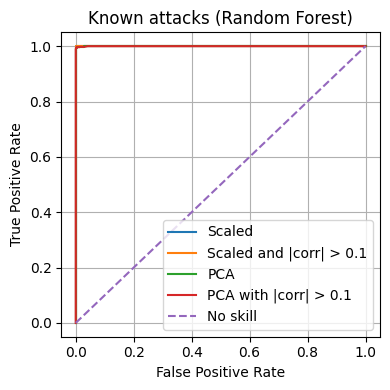

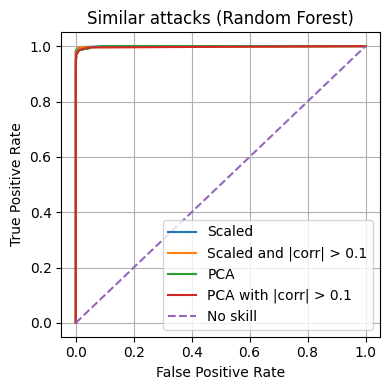

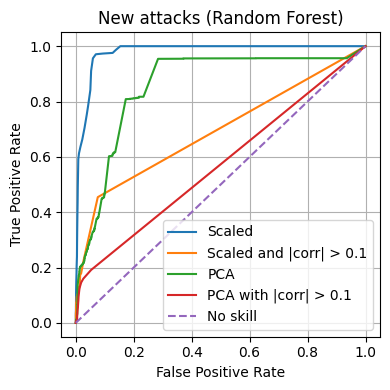

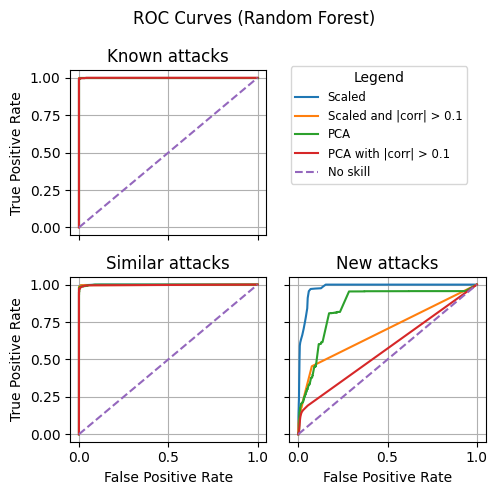

In [81]:
model_name = "Random Forest"
clf = RandomForestClassifier
clf_scaled_grid = RF_scaled_grid
clf_corr_gt1_scaled_grid = RF_corr_gt1_scaled_grid
clf_pca_grid = RF_pca_grid
clf_corr_gt1_pca_grid = RF_corr_gt1_pca_grid

#####

figure_path = f"{prepend_path}/report/figures/"
import os
from sklearn.metrics import roc_curve
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

clf_scaled = clf(**clf_scaled_grid.best_params_, random_state=random_state)
clf_scaled.fit(X_scaled_train, y_scaled_train)

clf_corr_gt1_scaled = clf(**clf_corr_gt1_scaled_grid.best_params_, random_state=random_state)
clf_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

clf_pca = clf(**clf_pca_grid.best_params_, random_state=random_state)
clf_pca.fit(X_pca_train, y_pca_train)

clf_corr_gt1_pca = clf(**clf_corr_gt1_pca_grid.best_params_, random_state=random_state)
clf_corr_gt1_pca.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

df_scaled_roc1 = pipeline_scaled(df=df_known_attacks, scaler=scaler)
_, _, X_known_attacks_scaled, _, _, y_known_attacks_scaled = test_train_val_split(df_scaled_roc1)
y_known_attacks_scaled_pred = clf_scaled.predict_proba(X_known_attacks_scaled)

df_corr_gt1_scaled_roc1 = pipeline_corr_gt1_scaled(df=df_known_attacks, scaler=scaler_gt1, cols=cols_corr_gt1)
_, _, X_known_attacks_corr_gt1_scaled, _, _, y_known_attacks_corr_gt1_scaled = test_train_val_split(df_corr_gt1_scaled_roc1)
y_known_attacks_corr_gt1_scaled_pred = clf_corr_gt1_scaled.predict_proba(X_known_attacks_corr_gt1_scaled)

df_pca_roc1 = pipeline_pca(df=df_known_attacks, scaler=scaler, pca=pca)
_, _, X_known_attacks_pca, _, _, y_known_attacks_pca = test_train_val_split(df_pca_roc1)
y_known_attacks_pca_pred = clf_pca.predict_proba(X_known_attacks_pca)

df_corr_gt1_pca_roc1 = pipeline_corr_gt1_pca(df=df_known_attacks, scaler=scaler_gt1, cols=cols_corr_gt1, pca=pca_corr_gt1)
_, _, X_known_attacks_corr_gt1_pca, _, _, y_known_attacks_corr_gt1_pca = test_train_val_split(df_corr_gt1_pca_roc1)
y_known_attacks_corr_gt1_pca_pred = clf_corr_gt1_pca.predict_proba(X_known_attacks_corr_gt1_pca)

df_scaled_roc = pipeline_scaled(df=df_similar_attacks, scaler=scaler)
_, _, X_similar_attacks_scaled, _, _, y_similar_attacks_scaled = test_train_val_split(df_scaled_roc)
y_similar_attacks_scaled_pred = clf_scaled.predict_proba(X_similar_attacks_scaled)

df_corr_gt1_scaled_roc = pipeline_corr_gt1_scaled(df=df_similar_attacks, scaler=scaler_gt1, cols=cols_corr_gt1)
_, _, X_similar_attacks_corr_gt1_scaled, _, _, y_similar_attacks_corr_gt1_scaled = test_train_val_split(df_corr_gt1_scaled_roc)
y_similar_attacks_corr_gt1_scaled_pred = clf_corr_gt1_scaled.predict_proba(X_similar_attacks_corr_gt1_scaled)

df_pca_roc = pipeline_pca(df=df_similar_attacks, scaler=scaler, pca=pca)
_, _, X_similar_attacks_pca, _, _, y_similar_attacks_pca = test_train_val_split(df_pca_roc)
y_similar_attacks_pca_pred = clf_pca.predict_proba(X_similar_attacks_pca)

df_corr_gt1_pca_roc = pipeline_corr_gt1_pca(df=df_similar_attacks, scaler=scaler_gt1, cols=cols_corr_gt1, pca=pca_corr_gt1)
_, _, X_similar_attacks_corr_gt1_pca, _, _, y_similar_attacks_corr_gt1_pca = test_train_val_split(df_corr_gt1_pca_roc)
y_similar_attacks_corr_gt1_pca_pred = clf_corr_gt1_pca.predict_proba(X_similar_attacks_corr_gt1_pca)

df_scaled_roc2 = pipeline_scaled(df=df_new_attacks, scaler=scaler)
_, _, X_new_attacks_scaled, _, _, y_new_attacks_scaled = test_train_val_split(df_scaled_roc2)
y_new_attacks_scaled_pred = clf_scaled.predict_proba(X_new_attacks_scaled)

df_corr_gt1_scaled_roc2 = pipeline_corr_gt1_scaled(df=df_new_attacks, scaler=scaler_gt1, cols=cols_corr_gt1)
_, _, X_new_attacks_corr_gt1_scaled, _, _, y_new_attacks_corr_gt1_scaled = test_train_val_split(df_corr_gt1_scaled_roc2)
y_new_attacks_corr_gt1_scaled_pred = clf_corr_gt1_scaled.predict_proba(X_new_attacks_corr_gt1_scaled)

df_pca_roc2 = pipeline_pca(df=df_new_attacks, scaler=scaler, pca=pca)
_, _, X_new_attacks_pca, _, _, y_new_attacks_pca = test_train_val_split(df_pca_roc2)
y_new_attacks_pca_pred = clf_pca.predict_proba(X_new_attacks_pca)

df_corr_gt1_pca_roc2 = pipeline_corr_gt1_pca(df=df_new_attacks, scaler=scaler_gt1, cols=cols_corr_gt1, pca=pca_corr_gt1)
_, _, X_new_attacks_corr_gt1_pca, _, _, y_new_attacks_corr_gt1_pca = test_train_val_split(df_corr_gt1_pca_roc2)
y_new_attacks_corr_gt1_pca_pred = clf_corr_gt1_pca.predict_proba(X_new_attacks_corr_gt1_pca)

fpr_scaled1, tpr_scaled1, _ = roc_curve(y_known_attacks_scaled, y_known_attacks_scaled_pred[:, 1])
fpr_corr_gt1_scaled1, tpr_corr_gt1_scaled1, _ = roc_curve(y_known_attacks_corr_gt1_scaled, y_known_attacks_corr_gt1_scaled_pred[:, 1])
fpr_pca1, tpr_pca1, _ = roc_curve(y_known_attacks_pca, y_known_attacks_pca_pred[:, 1])
fpr_corr_gt1_pca1, tpr_corr_gt1_pca1, _ = roc_curve(y_known_attacks_corr_gt1_pca, y_known_attacks_corr_gt1_pca_pred[:, 1])

fpr_scaled, tpr_scaled, _ = roc_curve(y_similar_attacks_scaled, y_similar_attacks_scaled_pred[:, 1])
fpr_corr_gt1_scaled, tpr_corr_gt1_scaled, _ = roc_curve(y_similar_attacks_corr_gt1_scaled, y_similar_attacks_corr_gt1_scaled_pred[:, 1])
fpr_pca, tpr_pca, _ = roc_curve(y_similar_attacks_pca, y_similar_attacks_pca_pred[:, 1])
fpr_corr_gt1_pca, tpr_corr_gt1_pca, _ = roc_curve(y_similar_attacks_corr_gt1_pca, y_similar_attacks_corr_gt1_pca_pred[:, 1])

fpr_scaled2, tpr_scaled2, _ = roc_curve(y_new_attacks_scaled, y_new_attacks_scaled_pred[:, 1])
fpr_corr_gt1_scaled2, tpr_corr_gt1_scaled2, _ = roc_curve(y_new_attacks_corr_gt1_scaled, y_new_attacks_corr_gt1_scaled_pred[:, 1])
fpr_pca2, tpr_pca2, _ = roc_curve(y_new_attacks_pca, y_new_attacks_pca_pred[:, 1])
fpr_corr_gt1_pca2, tpr_corr_gt1_pca2, _ = roc_curve(y_new_attacks_corr_gt1_pca, y_new_attacks_corr_gt1_pca_pred[:, 1])
figsize = (4,4)

plt.figure(figsize=figsize)
plt.plot(fpr_scaled1, tpr_scaled1, label="Scaled")
plt.plot(fpr_corr_gt1_scaled1, tpr_corr_gt1_scaled1, label="Scaled and |corr| > 0.1")
plt.plot(fpr_pca1, tpr_pca1, label="PCA")
plt.plot(fpr_corr_gt1_pca1, tpr_corr_gt1_pca1, label="PCA with |corr| > 0.1")
plt.plot([0, 1], [0, 1], linestyle="--", label="No skill")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title(f"Known attacks ({model_name})")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(f"{figure_path}/{model_name}_known_attacks_roc.png")
plt.show()

plt.figure(figsize=figsize)
plt.plot(fpr_scaled, tpr_scaled, label="Scaled")
plt.plot(fpr_corr_gt1_scaled, tpr_corr_gt1_scaled, label="Scaled and |corr| > 0.1")
plt.plot(fpr_pca, tpr_pca, label="PCA")
plt.plot(fpr_corr_gt1_pca, tpr_corr_gt1_pca, label="PCA with |corr| > 0.1")
plt.plot([0, 1], [0, 1], linestyle="--", label="No skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Similar attacks ({model_name})")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(f"{figure_path}/{model_name}_similar_attacks_roc.png")
plt.show()

plt.figure(figsize=figsize)
plt.plot(fpr_scaled2, tpr_scaled2, label="Scaled")
plt.plot(fpr_corr_gt1_scaled2, tpr_corr_gt1_scaled2, label="Scaled and |corr| > 0.1")
plt.plot(fpr_pca2, tpr_pca2, label="PCA")
plt.plot(fpr_corr_gt1_pca2, tpr_corr_gt1_pca2, label="PCA with |corr| > 0.1")
plt.plot([0, 1], [0, 1], linestyle="--", label="No skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"New attacks ({model_name})")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(f"{figure_path}/{model_name}_new_attacks_roc.png")
plt.show()

figsize = (5,5)
fig, axs = plt.subplots(2, 2, figsize=figsize, sharex=True, sharey=True)
ax=axs.flatten()
plt.suptitle(f"ROC Curves ({model_name})")

ax[0].plot(fpr_scaled1, tpr_scaled1, label="Scaled")
ax[0].plot(fpr_corr_gt1_scaled1, tpr_corr_gt1_scaled1, label="Scaled and |corr| > 0.1")
ax[0].plot(fpr_pca1, tpr_pca1, label="PCA")
ax[0].plot(fpr_corr_gt1_pca1, tpr_corr_gt1_pca1, label="PCA with |corr| > 0.1")
ax[0].plot([0, 1], [0, 1], linestyle="--", label="No skill")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title(f"Known attacks")
ax[0].grid()

ax[2].plot(fpr_scaled, tpr_scaled)
ax[2].plot(fpr_corr_gt1_scaled, tpr_corr_gt1_scaled)
ax[2].plot(fpr_pca, tpr_pca)
ax[2].plot(fpr_corr_gt1_pca, tpr_corr_gt1_pca)
ax[2].plot([0, 1], [0, 1], linestyle="--")
ax[2].set_xlabel("False Positive Rate")
ax[2].set_ylabel("True Positive Rate")
ax[2].set_title(f"Similar attacks")
ax[2].grid()

ax[3].plot(fpr_scaled2, tpr_scaled2)
ax[3].plot(fpr_corr_gt1_scaled2, tpr_corr_gt1_scaled2)
ax[3].plot(fpr_pca2, tpr_pca2)
ax[3].plot(fpr_corr_gt1_pca2, tpr_corr_gt1_pca2)
ax[3].plot([0, 1], [0, 1], linestyle="--")
ax[3].set_xlabel("False Positive Rate")
ax[3].set_title(f"New attacks")
ax[3].grid()

ax[1].axis("off")
fig.legend(loc="center", bbox_to_anchor=(0.75, 0.75), fontsize="small", title="Legend")

plt.tight_layout()
plt.savefig(f"{figure_path}/{model_name}_roc_all_small.png")
plt.show()